# Tutorial 1: Integrating adjacent DLPFC slices
This tutorial demonstrates STAligner's ablility to integrate multiple adjacent slices. The slices are sampled from human dorsolateral prefrontal cortex (DLPFC) and the processed data can be downloaded from https://drive.google.com/drive/folders/1pHJy2cB9BKqc3ny9IpvVhiw_8ukJMzPW?usp=share_link.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import ST_utils
# import train_STAligner
import STAligner

# the location of R (used for the mclust clustering)
import os
os.environ['R_HOME'] = "/home/tguo/tguo2/miniconda3/envs/env_STAligner/lib/R"
os.environ['R_USER'] = "/home/tguo/tguo2/miniconda3/envs/env_STAligner/lib/python3.7/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import torch
used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data

In [18]:
dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"
Batch_list = []
adj_list = []
sample_name=np.array(['151507','151508','151509','151510','151669','151670','151671','151672','151673','151674','151675','151676'])
IDX=[[0,1],[1,2],[2,3],[4,5],[5,6],[6,7],[8,9],[9,10],[10,11]]
for idx in np.arange(8,len(IDX)):
    
    section_ids = sample_name[IDX[idx]]
    print(section_ids)

    flags=''
    for i in np.arange(len(section_ids)):
        flags=flags+'_'+section_ids[i]

    for section_id in section_ids:
        print(section_id)
        input_dir = os.path.join(dirs+"scanpy_file/", section_id)
        adata = sc.read_visium(path=input_dir, count_file= 'filtered_feature_bc_matrix.h5', load_images=True)
        adata.var_names_make_unique(join="++")

        # read the annotation
        Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
        Ann_df.columns = ['Ground Truth']
        Ann_df[Ann_df.isna()] = "unknown"
        adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')

        # make spot name unique
        adata.obs_names = [section_id+'_'+x for x in adata.obs_names]

        # Constructing the spatial network
        STAligner.Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
        # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors

        # Normalization
        sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        adata = adata[:, adata.var['highly_variable']]

        adj_list.append(adata.uns['adj'])
        Batch_list.append(adata)
        adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
    adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
    adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
    print('adata_concat.shape: ', adata_concat.shape)
    adj_concat = np.asarray(adj_list[0].todense())
    for batch_id in range(1,len(section_ids)):
        adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
    adata_concat.uns['edgeList'] = np.nonzero(adj_concat)
    %%time
    adata_concat = STAligner.train_STAligner(adata_concat, verbose=True, knn_neigh = 50, device=used_device)
    cellnames=np.array([i.split('_')[0]+'-'+i.split('_')[1] for i in adata_concat.obs_names])
    embed=adata_concat.obsm['STAligner']
    embednames=['STAligner-'+str(i) for i in np.arange(embed.shape[1])]
    embed=pd.DataFrame(embed,index=cellnames,columns=embednames)
    embed.to_csv(dirs+"methods/STAligner_mat"+flags+".txt")

['151675' '151676']
151675


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


------Calculating spatial graph...
The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.
151676


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.
adata_concat.shape:  (7052, 2296)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs
STAligner(
  (conv1): GATConv(2296, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 2296, heads=1)
)
Pretrain with STAGATE...


100%|██████████| 500/500 [00:18<00:00, 27.41it/s]


Train with STAligner...


  0%|          | 0/500 [00:00<?, ?it/s]

Update spot triplets at epoch 500


 20%|██        | 100/500 [00:05<00:14, 26.90it/s]

Update spot triplets at epoch 600


 40%|███▉      | 199/500 [00:10<00:10, 28.07it/s]

Update spot triplets at epoch 700


 60%|█████▉    | 298/500 [00:16<00:07, 28.32it/s]

Update spot triplets at epoch 800


 80%|████████  | 400/500 [00:21<00:03, 28.71it/s]

Update spot triplets at epoch 900


100%|██████████| 500/500 [00:27<00:00, 18.29it/s]


## Concat the scanpy objects for multiple slices

In [36]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (15284, 946)


## Concat the spatial network for multiple slices

In [37]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

## Running STAligner

In [38]:
%%time
adata_concat = STAligner.train_STAligner(adata_concat, verbose=True, knn_neigh = 50, device=used_device)
cellnames=np.array([i.split('_')[0]+'-'+i.split('_')[1] for i in adata_concat.obs_names])
embed=adata_concat.obsm['STAligner']
embednames=['STAligner-'+str(i) for i in np.arange(embed.shape[1])]
embed=pd.DataFrame(embed,index=cellnames,columns=embednames)
embed.to_csv(dirs+"methods/STAligner_mat"+flags+".txt")

STAligner(
  (conv1): GATConv(946, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 946, heads=1)
)
Pretrain with STAGATE...


100%|██████████| 500/500 [00:25<00:00, 19.29it/s]


Train with STAligner...


  0%|          | 0/500 [00:00<?, ?it/s]

Update spot triplets at epoch 500


 20%|█▉        | 99/500 [00:15<00:21, 18.84it/s] 

Update spot triplets at epoch 600


 40%|███▉      | 199/500 [00:32<00:18, 16.67it/s]

Update spot triplets at epoch 700


 60%|█████▉    | 299/500 [00:51<00:12, 16.00it/s]

Update spot triplets at epoch 800


 80%|███████▉  | 399/500 [01:08<00:05, 18.49it/s]

Update spot triplets at epoch 900


100%|██████████| 500/500 [01:26<00:00,  5.81it/s]


CPU times: user 5min 44s, sys: 15.7 s, total: 6min
Wall time: 1min 53s


## Clustering

In [39]:
STAligner.mclust_R(adata_concat, num_cluster=7, used_obsm='STAligner')
adata_concat = adata_concat[adata_concat.obs['Ground Truth']!='unknown']

from sklearn.metrics import adjusted_rand_score as ari_score
print('mclust, ARI = %01.3f' % ari_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))
pd.DataFrame(adata_concat.obs['mclust']).to_csv(dirs+"metrics/STAligner_mclust.csv")

fitting ...

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%


mclust, ARI = 0.353


In [40]:
from sklearn.metrics.cluster import adjusted_rand_score
for section_id in section_ids:
    temp_adata = adata_concat[adata_concat.obs['slice_name']==str(section_id)]
    temp_obs = temp_adata.obs.dropna()
    temp_ARI = adjusted_rand_score(temp_obs['mclust'], temp_obs['Ground Truth'])
    print('ARI of section ID %s: %.3f' %(str(section_id), temp_ARI))

ARI of section ID 151669: 0.267
ARI of section ID 151670: 0.244
ARI of section ID 151671: 0.436
ARI of section ID 151672: 0.518


## Visualization

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


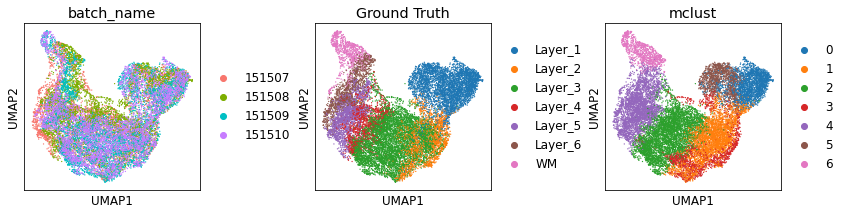

In [14]:
sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

section_color = ['#f8766d', '#7cae00', '#00bfc4', '#c77cff']
section_color_dict = dict(zip(section_ids, section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]
adata_concat.obs['mclust'] = pd.Series(STAligner.match_cluster_labels(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust'].values),
                                         index=adata_concat.obs.index, dtype='category')

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12

sc.pl.umap(adata_concat, color=['batch_name', 'Ground Truth', 'mclust'], ncols=3, 
           wspace=0.5, show=True)

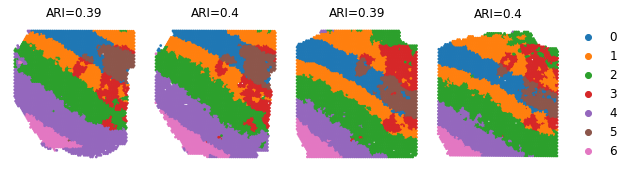

In [15]:
Batch_list = []
for section_id in section_ids:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt
spot_size = 200
title_size = 12
ARI_list = []
for bb in range(4):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['Ground Truth'], Batch_list[bb].obs['mclust']), 2))

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['mclust'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)
plt.show()